In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np


In [28]:
training_file_path = 'balabit_features_training.csv'
data = pd.read_csv(training_file_path)

In [29]:
testing_file_path = 'balabit_features_test.csv'
test_data = pd.read_csv(testing_file_path)


In [30]:
selected_columns = [
    'mean_v', 'sd_v', 'max_v', 'min_v', 'mean_vx', 'sd_vx', 'max_vx', 'min_vx',
    'mean_vy', 'sd_vy', 'max_vy', 'min_vy', 'mean_a', 'sd_a', 'max_a', 'min_a',
    'mean_jerk', 'sd_jerk', 'max_jerk', 'min_jerk', 'direction_of_movement'
]


In [31]:
train_cleaned = data.dropna(subset=selected_columns)[selected_columns]
test_cleaned = test_data.dropna(subset=selected_columns)[selected_columns]

In [32]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_cleaned)
test_scaled = scaler.transform(test_cleaned)


In [33]:
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

In [34]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train_pca)


KMeans(n_clusters=10, random_state=42)

In [35]:
test_labels = kmeans.predict(test_pca)

In [36]:
distances = np.linalg.norm(test_pca - kmeans.cluster_centers_[test_labels], axis=1)

In [37]:
test_data['cluster'] = test_labels
test_data['distance_to_center'] = distances

In [38]:
test_data.to_csv('clustered_testing_data_fixed_10_clusters.csv', index=False)

In [39]:
print(test_data.head())

   type_of_action  traveled_distance_pixel  elapsed_time  \
0               3               357.084960         1.170   
1               3               369.966397         1.591   
2               3               993.948298         6.849   
3               1              1610.385871         4.431   
4               3               305.408959         0.780   

   direction_of_movement  straightness  num_points  sum_of_angles  mean_curv  \
0                      7      0.519784          10       3.697425  -0.090787   
1                      6      0.606582          14       5.039419   0.079153   
2                      1      0.787196          19      -0.545368   0.209308   
3                      4      0.409789          27     -24.136770   0.207996   
4                      2      0.954445           7      12.897938   0.011900   

    sd_curv  max_curv  ...      max_jerk      min_jerk  a_beg_time  class  \
0  0.267935  0.177068  ...  6.351428e+04  -64410.62468       0.218     12   
1  0

In [40]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(train_pca)
gmm_labels = gmm.predict(test_pca)
gmm_probabilities = gmm.predict_proba(test_pca)

# Add GMM labels and probability scores to the test dataset
test_data['gmm_cluster'] = gmm_labels
test_data['gmm_probabilities'] = gmm_probabilities.max(axis=1)  # Highest probability for each point

# Saving GMM-based results (optional)
test_data.to_csv('gmm_clustered_testing_data_fixed_10_clusters.csv', index=False)

# Display the first few rows with GMM results
print(test_data.head())

   type_of_action  traveled_distance_pixel  elapsed_time  \
0               3               357.084960         1.170   
1               3               369.966397         1.591   
2               3               993.948298         6.849   
3               1              1610.385871         4.431   
4               3               305.408959         0.780   

   direction_of_movement  straightness  num_points  sum_of_angles  mean_curv  \
0                      7      0.519784          10       3.697425  -0.090787   
1                      6      0.606582          14       5.039419   0.079153   
2                      1      0.787196          19      -0.545368   0.209308   
3                      4      0.409789          27     -24.136770   0.207996   
4                      2      0.954445           7      12.897938   0.011900   

    sd_curv  max_curv  ...  a_beg_time  class    session  n_from  n_to  \
0  0.267935  0.177068  ...       0.218     12  126772600       5    15   
1  0.29854

In [41]:
# The normal user data point
normal_user_data_point = {
    'mean_v': 634.152499,
    'sd_v': 1061.6933,
    'max_v': 5162.3637,
    'min_v': 2.3889,
    'mean_vx': -133.4056,
    'sd_vx': 907.0929,
    'max_vx': 3300.0,
    'min_vx': -5100.0,
    'mean_vy': -31.9546,
    'sd_vy': 834.9679,
    'max_vy': 1900.0,
    'min_vy': -4900.0,
    'mean_a': 26692.5428,
    'sd_a': 87552.8379,
    'max_a': 435648.1302,
    'min_a': -39709.2721,
    'mean_jerk': 2782076.0583,
    'sd_jerk': 9098248.5988,
    'max_jerk': 43107871.5131,
    'min_jerk': -4296965.0754,
    'direction_of_movement': 45
}

# Convert the data point into a DataFrame for easier manipulation
user_data_df = pd.DataFrame([normal_user_data_point])

# Standardize the new data point using the same scaler that was used for training data
user_scaled = scaler.transform(user_data_df)

# Apply PCA to the scaled data using the same PCA model fitted on the training data
user_pca = pca.transform(user_scaled)

# Predict the cluster for the new data point using the trained KMeans model
user_cluster = kmeans.predict(user_pca)

# Calculate the distance from the new data point to its assigned cluster center
user_distance = np.linalg.norm(user_pca - kmeans.cluster_centers_[user_cluster], axis=1)

# Calculate the distance from the new data point to all cluster centers
all_distances = np.linalg.norm(user_pca - kmeans.cluster_centers_, axis=1)

# Output the cluster assignment, distance to assigned cluster, and distances to all clusters
print(f"Cluster assignment for the normal user data point: {user_cluster[0]}")
print(f"Distance to the assigned cluster center: {user_distance[0]}")
print(f"Distances to all cluster centers: {all_distances}")


Cluster assignment for the normal user data point: 0
Distance to the assigned cluster center: 16.53329085343451
Distances to all cluster centers: [16.53329085 61.70571681 58.01951505 18.30512398 26.04736723 47.79855088
 50.39060061 63.78820007 17.41657038 23.74749179]


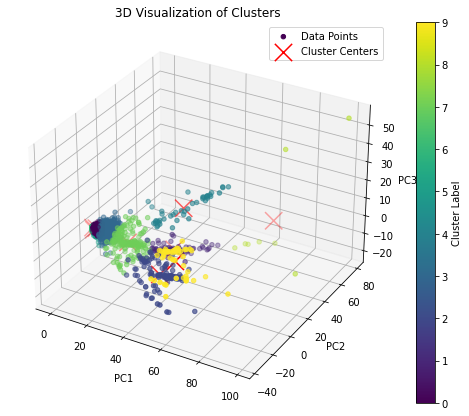

In [42]:
# Importing necessary libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3 dimensions for visualization
pca_3d = PCA(n_components=3)
train_pca_3d = pca_3d.fit_transform(train_scaled)

# Fit the KMeans model on the 3D PCA-transformed data
kmeans_3d = KMeans(n_clusters=10, random_state=42)
kmeans_3d.fit(train_pca_3d)

# Predict the clusters
train_labels_3d = kmeans_3d.predict(train_pca_3d)

# Create a 3D scatter plot to visualize the clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with each cluster in a different color
scatter = ax.scatter(train_pca_3d[:, 0], train_pca_3d[:, 1], train_pca_3d[:, 2], 
                     c=train_labels_3d, cmap='viridis', marker='o')

# Adding cluster centers for KMeans
centers_3d = kmeans_3d.cluster_centers_
ax.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2], 
           s=300, c='red', marker='x', label='Cluster Centers')

# Labeling the axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Title and legend
plt.title('3D Visualization of Clusters')
plt.legend(['Data Points', 'Cluster Centers'])

# Show color bar (optional)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Show the plot
plt.show()


In [43]:
# The normal user data point
bot_data_point_1 = {
    'mean_v': 2.0,  # Very fast average velocity
    'sd_v': 0.05,   # Low variability in velocity
    'max_v': 2.5,   # High maximum velocity
    'min_v': 1.8,   # High minimum velocity
    'mean_vx': 2.0, # Fast x-axis movement
    'sd_vx': 0.02,  # Very low variation in x-axis movement
    'max_vx': 2.4,  # High max x-axis speed
    'min_vx': 1.7,  # High min x-axis speed
    'mean_vy': 0.1, # Very slow or minimal y-axis movement (straight line)
    'sd_vy': 0.01,  # Almost no variation in y-axis movement
    'max_vy': 0.12, # Low max y-axis speed
    'min_vy': 0.08, # Low min y-axis speed
    'mean_a': 0.01, # Very low average acceleration
    'sd_a': 0.005,  # Low variation in acceleration
    'max_a': 0.02,  # Low max acceleration
    'min_a': 0.005, # Low m'mean_v': 20459.91764802422, 'sd_v': 67363.95217385978, 'max_v': 223569.6987437253, 'min_v': 0.0, 'mean_vx': 110.34108280028127, 'sd_vx': 109.71152990748796, 'max_vx': 201.03134931913596, 'min_vx': -59.24363840073928, 'mean_vy': 72.18719062743865, 'sd_vy': 45.54510763635133, 'max_vy': 100.72875357322202, 'min_vy': 0.0, 'mean_a': 61.741777715633795, 'sd_a': 90.26648721083757, 'max_a': 161.84612593172574, 'min_a': 0.0, 'mean_jerk': 47.190454516094924, 'sd_jerk': 61.983809596898716, 'max_jerk': 180.3512668147491, 'min_jerk': 0.0, 'direction_of_movement': 33.182717780330215in acceleration
    'mean_jerk': 0.001,  # Almost no jerky movement
    'sd_jerk': 0.0005,   # Very smooth movement
    'max_jerk': 0.002,   # Very low jerk max
    'min_jerk': 0.0008,  # Minimal jerk
    'direction_of_movement': 0  # No significant direction change
}
# Convert the data point into a DataFrame for easier manipulation
user_data_df = pd.DataFrame([bot_data_point_1])

# Standardize the new data point using the same scaler that was used for training data
# user_scaled = scaler.transform(user_data_df)

# Apply PCA to the scaled data using the same PCA model fitted on the training data
user_pca = pca.transform(user_data_df)

# Predict the cluster for the new data point using the trained KMeans model
user_cluster = kmeans.predict(user_pca)

# Calculate the distance from the new data point to its assigned cluster center
user_distance = np.linalg.norm(user_pca - kmeans.cluster_centers_[user_cluster], axis=1)

# Calculate the distance from the new data point to all cluster centers
all_distances = np.linalg.norm(user_pca - kmeans.cluster_centers_, axis=1)

# Output the cluster assignment, distance to assigned cluster, and distances to all clusters
print(f"Cluster assignment for the bot user data point: {user_cluster[0]}")
print(f"Distance to the assigned cluster center: {user_distance[0]}")
print(f"Distances to all cluster centers: {all_distances}")


Cluster assignment for the bot user data point: 3
Distance to the assigned cluster center: 4.228791755217608
Distances to all cluster centers: [ 4.24640747 60.6336179  54.61419538  4.22879176 20.18593952 45.15397913
 47.06314078 61.58420711  4.34680782 14.39455865]


C:\Users\Pranav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [45]:
# Assuming you have already performed KMeans clustering and have cluster labels
import pandas as pd

# Convert KMeans cluster labels into a DataFrame for easier counting
kmeans_cluster_labels = pd.Series(kmeans)

# Count the number of points in each cluster
kmeans_cluster_counts = kmeans_cluster_labels.value_counts().sort_index()

# Display the result
print("Number of points in each KMeans cluster:")
print(kmeans_cluster_counts)


Number of points in each KMeans cluster:
KMeans(n_clusters=10, random_state=42)    1
Name: count, dtype: int64
